### Creates different kinds of plots for a single transmon with two qubits.

In [13]:
from typing import List, Tuple
import numpy as np
import scipy.linalg
from matplotlib import pyplot as plt

import four_level_transmons.custom_gates as custom_gates
import four_level_transmons.plotting as plotting
import four_level_transmons.utilities as utilities
import four_level_transmons.notebook_utils as notebook_utils
from c3.model import Model
from c3.utils import qt_utils
from c3.utils import tf_utils
from c3.libraries import constants

np.set_printoptions(linewidth=300)

### Helper functions and preparation

In [14]:
# Helper functions
def getModel() -> Model:
    qubit_levels = [5]
    qubit_frequencies = [5e9]
    anharmonicities = [-300e6]
    t1s = [25e-6]
    t2stars = [35e-6]
    qubit_temps = 50e-3
    couplingStrength = 20e6
    qubits = utilities.createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s, t2stars, qubit_temps)
    coupling = utilities.createChainCouplings([couplingStrength], qubits)
    model = Model(qubits, coupling)
    model.set_lindbladian(False)
    model.set_dressed(False)
    model.set_FR(False)
    return model


def getHamiltonian():
    return getModel().get_Hamiltonian()


def cutSpectrum(frequencies: np.array, amplitudes: np.array, limits: Tuple[float, float]) -> Tuple[np.array, np.array]:
    """
    Cuts the two lists of frequencies and corresponding amplitudes at a lower and upper frequency cutoff. Returns both lists after cutting.
    """
    leftCut = np.argwhere(frequencies > limits[0]).flatten()
    leftIdx = leftCut[0] if len(leftCut) > 0 else 0
    rightCut = np.argwhere(frequencies < limits[1]).flatten()
    rightIdx = rightCut[-1] if len(rightCut) > 0 else -1
    return frequencies[leftIdx:rightIdx], amplitudes[leftIdx:rightIdx]

In [34]:
baseDir = '/home/user/Schreibtisch/results/4-level qubit/single transmon/2 LOs/double iSWAP 40ns/'
propagator = np.load(baseDir + 'propagator_after.npy')
#propagatorShort = np.load(baseDir + 'propagator_after_0.01ns_10steps.npy')
#hamiltonian = np.load(baseDir + 'hamiltonian_timedependent_after.npy')
time, signal = np.load(baseDir + 'signal_after.npy')
name = 'double_iswap'

### Reads a propagator from a file and plots it

Infidelity:  [0.00441083]


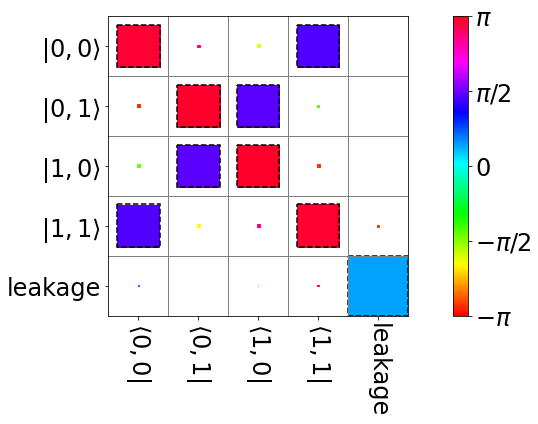

0.0459987593608031


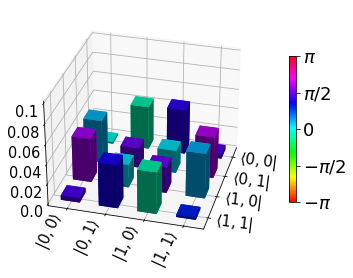

In [35]:
# Load and project the propagator
propagatorProjected = tf_utils.tf_project_to_comp(
    propagator, dims=[5], index=[0, 1], outdims=[4]
)

# Define an ideal gate and compute the fidelity
#ideal = qt_utils.np_kron_n([constants.GATES["rz90p"], constants.Id])
#ideal = custom_gates.GATE_CZ_t1q2_t2q2
#ideal = np.eye(16) + 0.0j * np.eye(16)
ideal = np.array([[1,0,0,-1j], [0,1,-1j,0], [0,-1j,1,0], [-1j,0,0,1]]) / np.sqrt(2.0)
#ideal = constants.ISWAP
idealPadded = qt_utils.pad_matrix(ideal, propagator.shape[0] - ideal.shape[0], 'fulluni')
print("Infidelity: ", 1.0 - tf_utils.tf_unitary_overlap(propagatorProjected, ideal).numpy())

# Correct the global phase in the propagator, which might be different from the ideal gate
phase = np.angle(ideal[0,0]) - np.angle(propagator[0,0])
propagatorCorrected = propagator * np.exp(1.0j * phase)
propagatorCorrectedProjected = tf_utils.tf_project_to_comp(
    propagatorCorrected, dims=[5], index=[0, 1], outdims=[4]
)

# Create the plots
baseDir = "/home/user"
labelsX = utilities.createSingleTransmonQubitLabels(makeLatexBras=True, labelLeakageAsNumbers=False)
labelsY = utilities.createSingleTransmonQubitLabels(makeLatexKets=True, labelLeakageAsNumbers=False)
plotting.plotComplexMatrixHinton(propagator, maxAbsolute=1, xlabels=labelsX, ylabels=labelsY, gridColour="gray",
                                 filename=f'{baseDir}/{name}_propagator.pdf', colourMap='hsv', tickLabelSize=24,
                                 comparisonMatrix=idealPadded,
                                 addAbsValueAsText=False
                                 )

#plotting.plotComplexMatrix(propagatorCorrectedProjected, colourMap='hsv', xlabels=labelsX[:4], ylabels=labelsY[:4],
#                           filename=f'{baseDir}/rx90p_q2_propagator_3d.svg')
#plotting.plotComplexMatrix(propagatorCorrected, colourMap='hsv', xlabels=labelsX, ylabels=labelsY,
#                           filename=f'{baseDir}/rx90p_q2_propagator_3d.svg')
zmax = np.max(np.abs(propagatorCorrectedProjected - ideal))
print(zmax)
plotting.plotComplexMatrix(propagatorCorrectedProjected - ideal, xlabels=labelsY[:4], ylabels=labelsX[:4],
                           filename=f'{baseDir}/{name}_propagator_diff.pdf',
                           colourMap='hsv', zlimits=(0.0, 1.05*zmax), zticks=np.round(np.arange(0.0, 0.11, 0.02), 3))

### Reads a time dependent signal and plots it

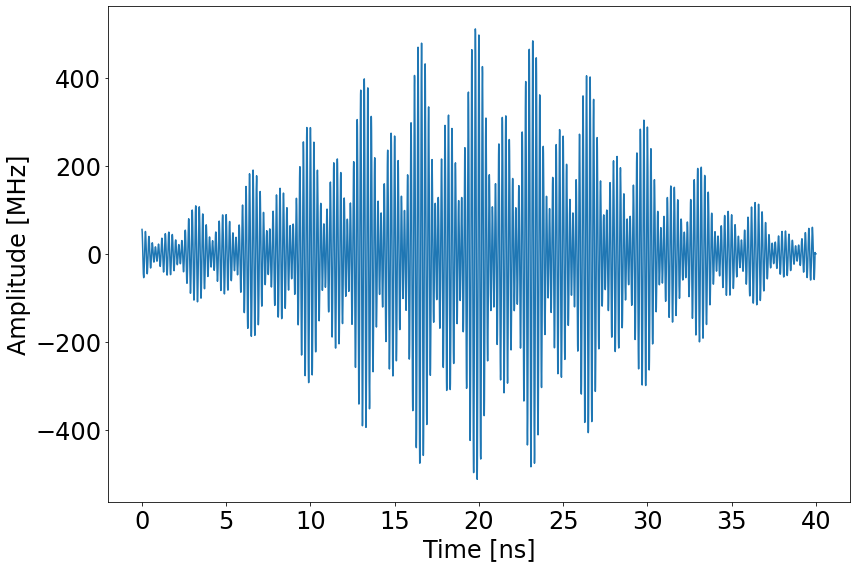

In [36]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(time * 1e9, signal / 1e6)
ax.set_xlabel("Time [ns]", fontsize=24)
ax.set_ylabel("Amplitude [MHz]", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.savefig(f'/home/user/{name}_signal.pdf', bbox_inches="tight", dpi=100)
plt.show()

### Plots the frequency spectrum of the above signal

/tmp/ipykernel_20451/822000803.py:70: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_gdpPercapinches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(filename, bbox_gdpPercapinches="tight", dpi=100)


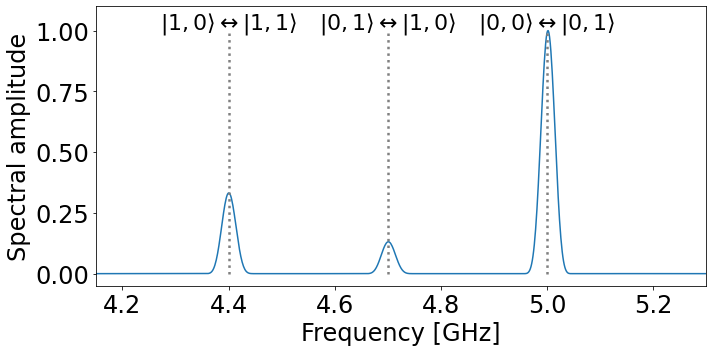

In [37]:
def plotSpectrum(time: np.array, signal: np.array, frequencyRange: Tuple[float, float], stateEnergies: List[float], normalise=False, addLabels=True, filename=None, paddingFactor=20) -> None:
    # Pad the signal with zeros for better resolution
    if paddingFactor != 1:
        time2 = np.arange(time[0], paddingFactor*time[-1], time[1]-time[0])
        signal2 = np.zeros(paddingFactor*len(signal))
        signal2[0:len(signal)] = signal
    else:
        time2 = time
        signal2 = signal

    # Calculate the spectrum
    freq_signal = np.fft.rfft(signal2)
    freq = np.fft.rfftfreq(len(time2), time2[-1] / len(time2))
    freq_signal = freq_signal[:len(freq_signal)//2]
    freq = freq[:len(freq)//2]
    freq, freq_signal = cutSpectrum(freq, freq_signal, frequencyRange)
    if normalise:
        freq_signal /= np.max(np.abs(freq_signal))

    # Create the plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.subplots(1, 1)
    plt.plot(freq / 1e9, np.abs(freq_signal)**2)
    #plt.plot(freq / 1e9, freq_signal.real, label="real")
    #plt.plot(freq / 1e9, freq_signal.imag, label="imag")
    #plt.legend()
    plt.xlabel("Frequency [GHz]", fontsize=24)
    plt.ylabel("Spectral amplitude", fontsize=24)
    plt.xlim(np.min(freq) / 1e9, np.max(freq) / 1e9)
    plt.ylim(-0.05, 1.1)
    ax.tick_params(axis='both', which='major', labelsize=24)

    # Add labels for the model's resonances
    if addLabels:
        # Calculate all resonances
        #stateEnergies = notebook_utils.getEnergiesFromHamiltonian(getHamiltonian())
        transitions = notebook_utils.calculateTransitions(stateEnergies, utilities.createSingleTransmonQubitLabels(makeLatexKets=True))

        # only transitions within a range
        inRange = [s for s in transitions if frequencyRange[0] < s[0] < frequencyRange[1]]
        energies = np.array([s[0] for s in inRange])
        labels = np.array([s[1] for s in inRange])
        sortedIndices = np.argsort(energies)
        sortedEnergies = energies[sortedIndices]

        # a tick for each transition energy
        ymax = 1.0 #np.max(np.abs(freq_signal))
        transitionSpacing = (frequencyRange[1] - frequencyRange[0]) / 10
        previousShifted = 0
        for i, E in enumerate(sortedEnergies):
            if i > 0 and abs(sortedEnergies[i] - sortedEnergies[i - 1]) < transitionSpacing:
                y = ymax * ((8.0 - previousShifted) / 9)
                previousShifted = (previousShifted + 1) % 4
            else:
                y = ymax
                previousShifted = 0
            ax.vlines(sortedEnergies[i] / 1e9, 0.0, y, colors=["grey"], linestyles=":", lw=2.5)
            ax.annotate(
                text=labels[sortedIndices[i]].replace(' - ', '$\\leftrightarrow$'),
                xy=(E / 1e9, 1.01*y),
                xycoords="data",
                #verticalalignment="bottom",
                horizontalalignment="center",
                #rotation=270,
                fontsize=22
            )

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_gdpPercapinches="tight", dpi=100)
    plt.show()

#t_final=1e-11
#dt=1e-10
#allStateEnergies = notebook_utils.getEnergiesFromPropagator(propagatorShort, t_final=1e-12)
#diag = np.diagonal(propagatorShort)
#print(diag)
#allStateEnergies = -np.angle(diag) / (2 * np.pi * 1e-11)
#print(np.array(notebook_utils.getEnergiesFromHamiltonian(getHamiltonian())) - np.array(allStateEnergies))

#H = hamiltonian[int(hamiltonian.shape[0]/2)]
#allStateEnergies = notebook_utils.getEnergiesFromHamiltonian(H)
#print("Stark shift: ", np.array(notebook_utils.getEnergiesFromHamiltonian(getHamiltonian())) - np.array(allStateEnergies))
allStateEnergies = notebook_utils.getEnergiesFromHamiltonian(getHamiltonian())

#tau = t_final / dt
#U = np.float_power(propagatorShort, 1.0 / tau)
#diag = np.diagonal(propagatorShort)
#allStateEnergies = -np.angle(diag) / (2 * np.pi * 1e-11)
plotSpectrum(time, signal, (4.15e9, 5.3e9), stateEnergies=allStateEnergies, addLabels=True, filename=f'/home/user/{name}_spectrum.pdf', normalise=True)
#plotSpectrum(time, signal, (4.6e9, 4.8e9), addLabels=True, filename=f'/home/user/{name}_spectrum.pdf', normalise=True)